# EMBA Statistics Data Project

UW Foster School of Business

Alexey Rybak

Monthly 22

Problem Statement: understanding the optimal content structure for online education courses. 


### Imports and function definitions

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.graphics.gofplots import ProbPlot



In [3]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [4]:
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
  """
  Function to reproduce the 4 base plots of an OLS model in R.

  ---
  Inputs:

  X: A numpy array or pandas dataframe of the features to use in building the linear regression model

  y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

  model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
  """

  if not model_fit:
      model_fit = sm.OLS(y, sm.add_constant(X)).fit()

  # create dataframe from X, y for easier plot handling
  dataframe = pd.concat([X, y], axis=1)

  # model values
  model_fitted_y = model_fit.fittedvalues
  # model residuals
  model_residuals = model_fit.resid
  # normalized residuals
  model_norm_residuals = model_fit.get_influence().resid_studentized_internal
  # absolute squared normalized residuals
  model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
  # absolute residuals
  model_abs_resid = np.abs(model_residuals)
  # leverage, from statsmodels internals
  model_leverage = model_fit.get_influence().hat_matrix_diag
  # cook's distance, from statsmodels internals
  model_cooks = model_fit.get_influence().cooks_distance[0]

  plot_lm_1 = plt.figure()
  plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

  plot_lm_1.axes[0].set_title('Residuals vs Fitted')
  plot_lm_1.axes[0].set_xlabel('Fitted values')
  plot_lm_1.axes[0].set_ylabel('Residuals');

  # annotations
  abs_resid = model_abs_resid.sort_values(ascending=False)
  abs_resid_top_3 = abs_resid[:3]
  for i in abs_resid_top_3.index:
      plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

  QQ = ProbPlot(model_norm_residuals)
  plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
  plot_lm_2.axes[0].set_title('Normal Q-Q')
  plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
  plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
  # annotations
  abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
  abs_norm_resid_top_3 = abs_norm_resid[:3]
  for r, i in enumerate(abs_norm_resid_top_3):
      plot_lm_2.axes[0].annotate(i,
                                 xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                     model_norm_residuals[i]));

  plot_lm_3 = plt.figure()
  plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
  sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_3.axes[0].set_title('Scale-Location')
  plot_lm_3.axes[0].set_xlabel('Fitted values')
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
  abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
  abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
  for i in abs_norm_resid_top_3:
      plot_lm_3.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_norm_residuals_abs_sqrt[i]));


  plot_lm_4 = plt.figure();
  plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
  sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
#  plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
#  plot_lm_4.axes[0].set_ylim(-3, 5)
  plot_lm_4.axes[0].set_title('Residuals vs Leverage')
  plot_lm_4.axes[0].set_xlabel('Leverage')
  plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
  leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
  for i in leverage_top_3:
      plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));

  p = len(model_fit.params) # number of model parameters
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50),
        'Cook\'s distance') # 0.5 line
  graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50)) # 1 line
  plot_lm_4.legend(loc='upper right');


In [5]:
nRowsRead = None # specify 'None' if want to read whole file
# vgsales-12-4-2019-short.csv has 55792 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('udemy_courses.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'udemy_courses.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 3678 rows and 12 columns


## Data munging

In [6]:
df1.dropna(inplace=True)
df1['published_date'] = pd.to_datetime(df1['published_timestamp'])
df1['time_elapsed'] = (df1.published_date.dt.tz_localize(None) - pd.to_datetime('2011-01-01')).dt.total_seconds()
df1 = pd.concat([df1,pd.get_dummies(df1['level'], prefix='level',dummy_na=True)],axis=1).drop(['level'],axis=1)
df1 = pd.concat([df1,pd.get_dummies(df1['subject'], prefix='subject',dummy_na=True)],axis=1).drop(['subject'],axis=1)
df1.time_elapsed = df1.time_elapsed/(3600*24)
df1.drop(columns=['published_timestamp','level_nan', 'published_date', 'is_paid', 'course_id', 'course_title', 'url', 'subject_nan'], inplace=True)
df1.rename(columns={'level_All Levels': 'all_levels', 'level_Beginner Level': 'beginner_level', 'level_Expert Level': 'expert_level', 'level_Intermediate Level': 'intermediate_level', 'subject_Business Finance': 'business_finance', 'subject_Graphic Design': 'graphic_design', 'subject_Musical Instruments': 'musical_instruments', 'subject_Web Development': 'web_development'}, inplace=True)
df1.to_csv(r'data.csv', index = False)


In [7]:
df1 = df1[(df1['num_lectures'] > 0)]
num_data = ['num_subscribers', 'price', 'num_reviews', 'num_lectures', 'content_duration', 'time_elapsed']
x = df1.drop(['num_subscribers'], axis=1)
y = df1['num_subscribers']

## Raw data: multiple linear regression model (OLS)

In [8]:
data = list(df1.columns)
data.remove('num_subscribers')

model_params = 'num_subscribers ~ '
for i in data:
    model_params += " + " + i


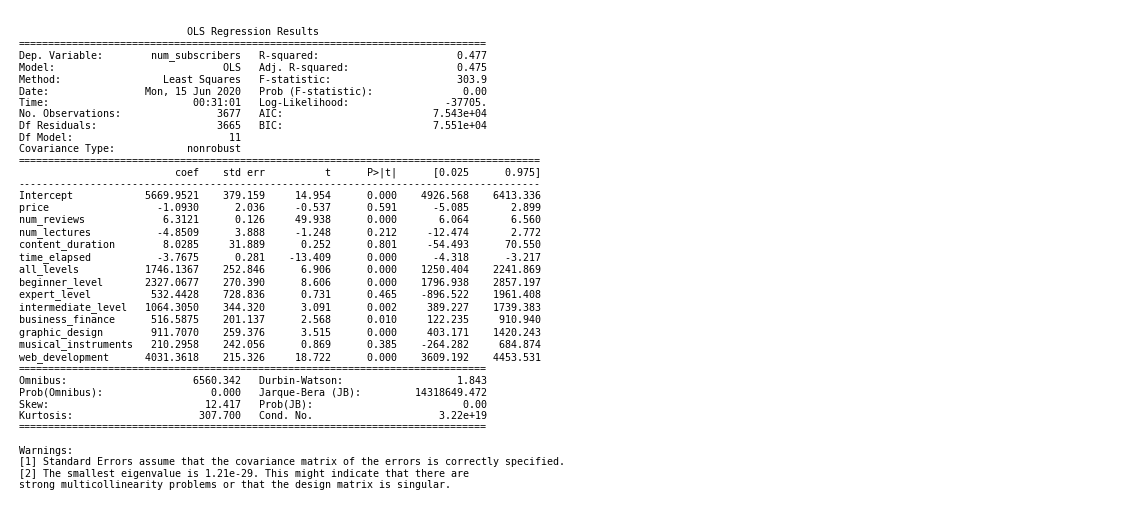

In [9]:
model = ols(model_params, data = df1).fit()
plt.rc('figure', figsize=(16, 8))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('reg_output.png')

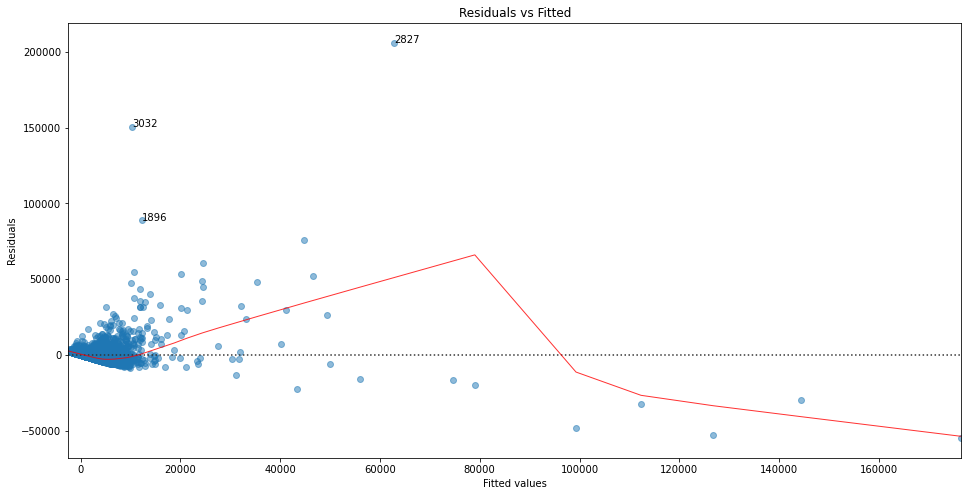

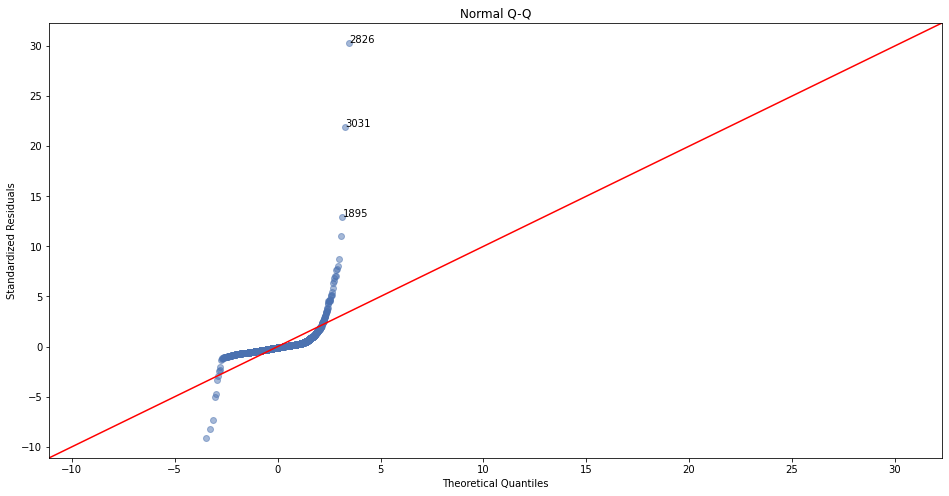

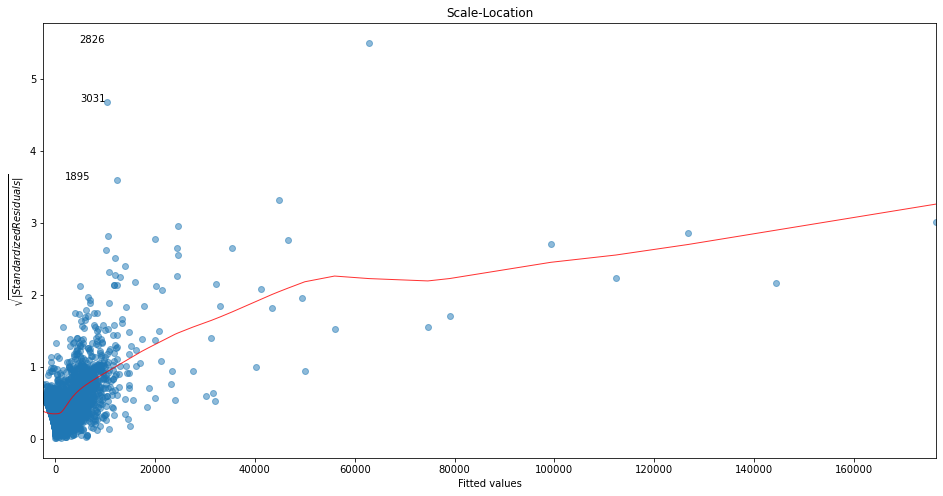

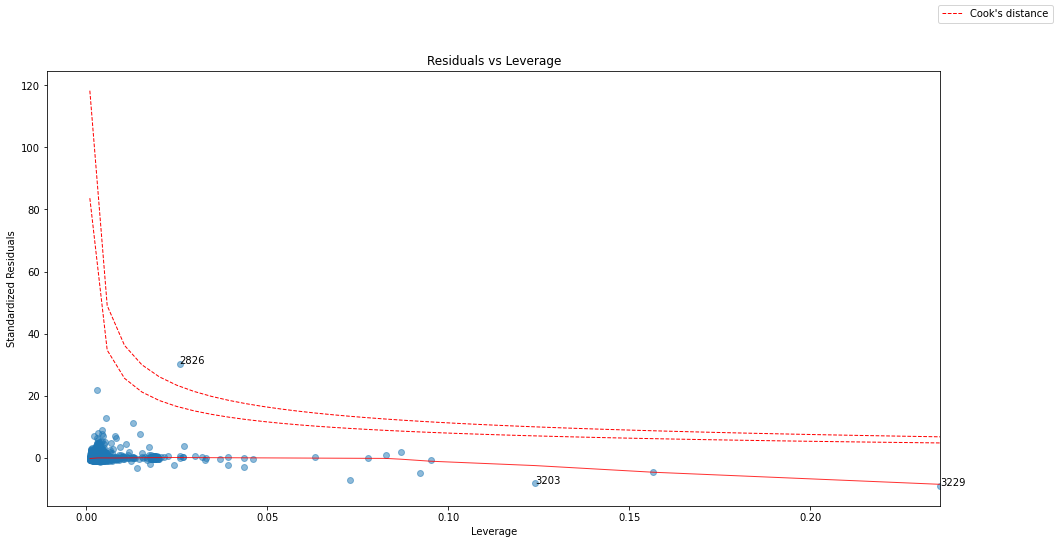

In [14]:
diagnostic_plots(x, y)

### Individual scatterplots

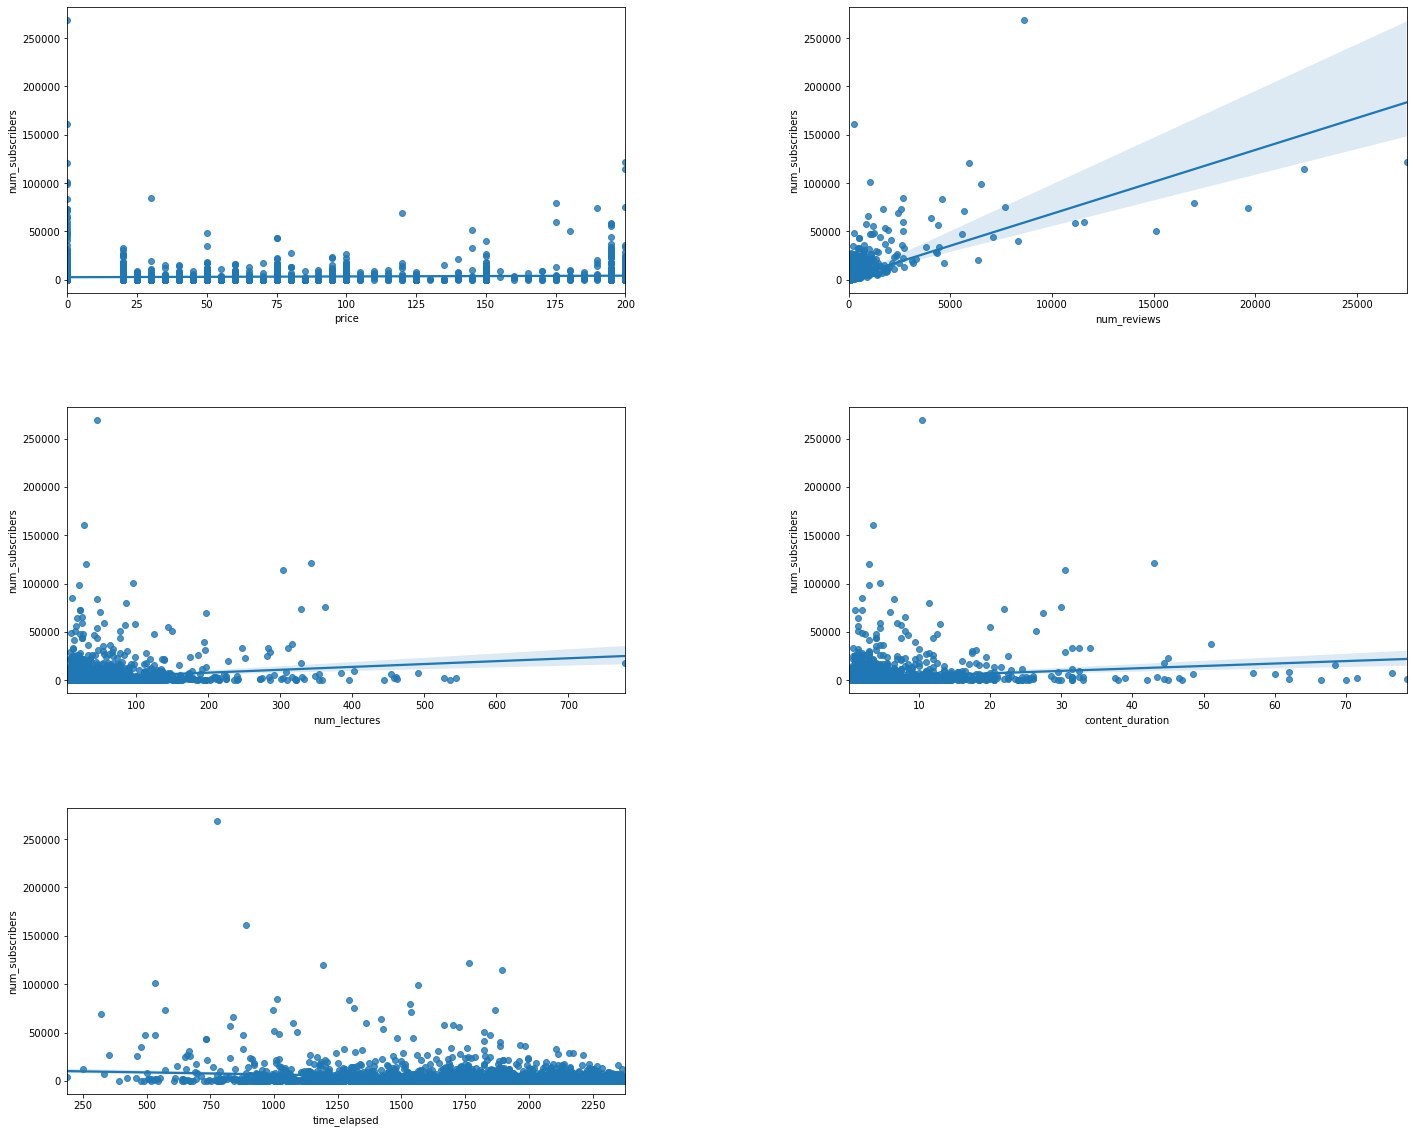

In [15]:
fig = plt.figure(figsize=(24,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1

for factor in num_data:
    if factor != 'num_subscribers':
        ax = fig.add_subplot(3, 2, i)
        g = sns.regplot(data=df1, x = factor, y="num_subscribers", ax=ax)
        i += 1

plt.savefig('reg_scatterplots.png')

### Individual histograms

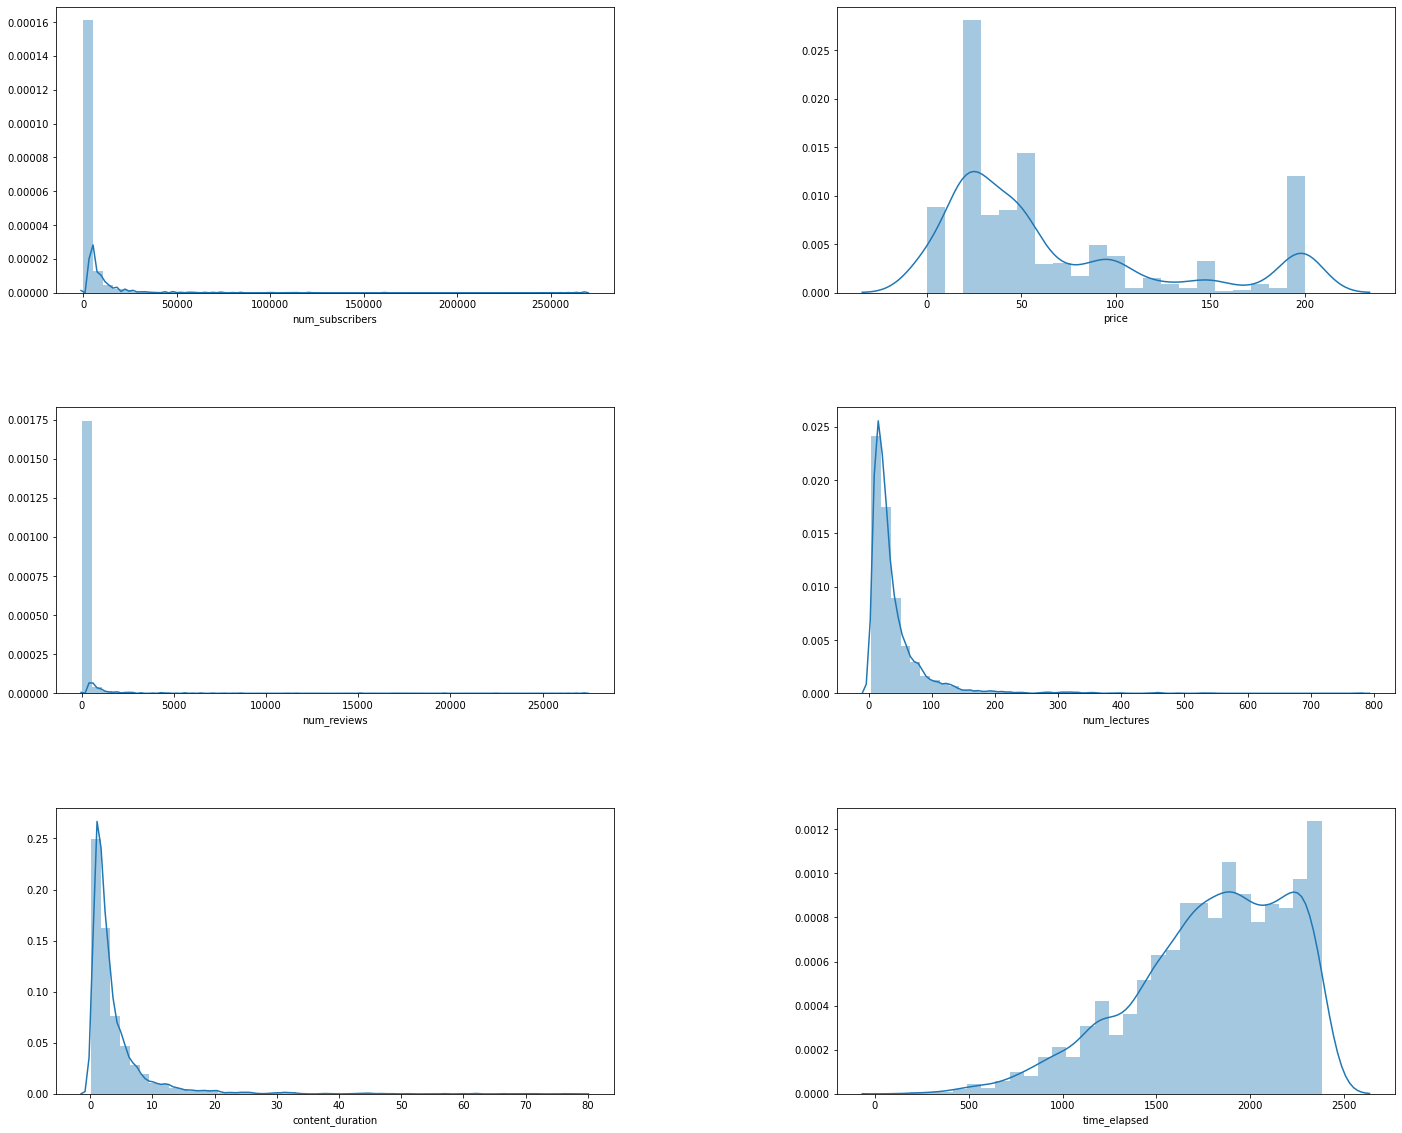

In [16]:
fig = plt.figure(figsize=(24,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1

for factor in num_data:
    ax = fig.add_subplot(3, 2, i)
    g = sns.distplot(df1[factor])
    i += 1

plt.savefig('reg_histograms.png')

### Boxplots

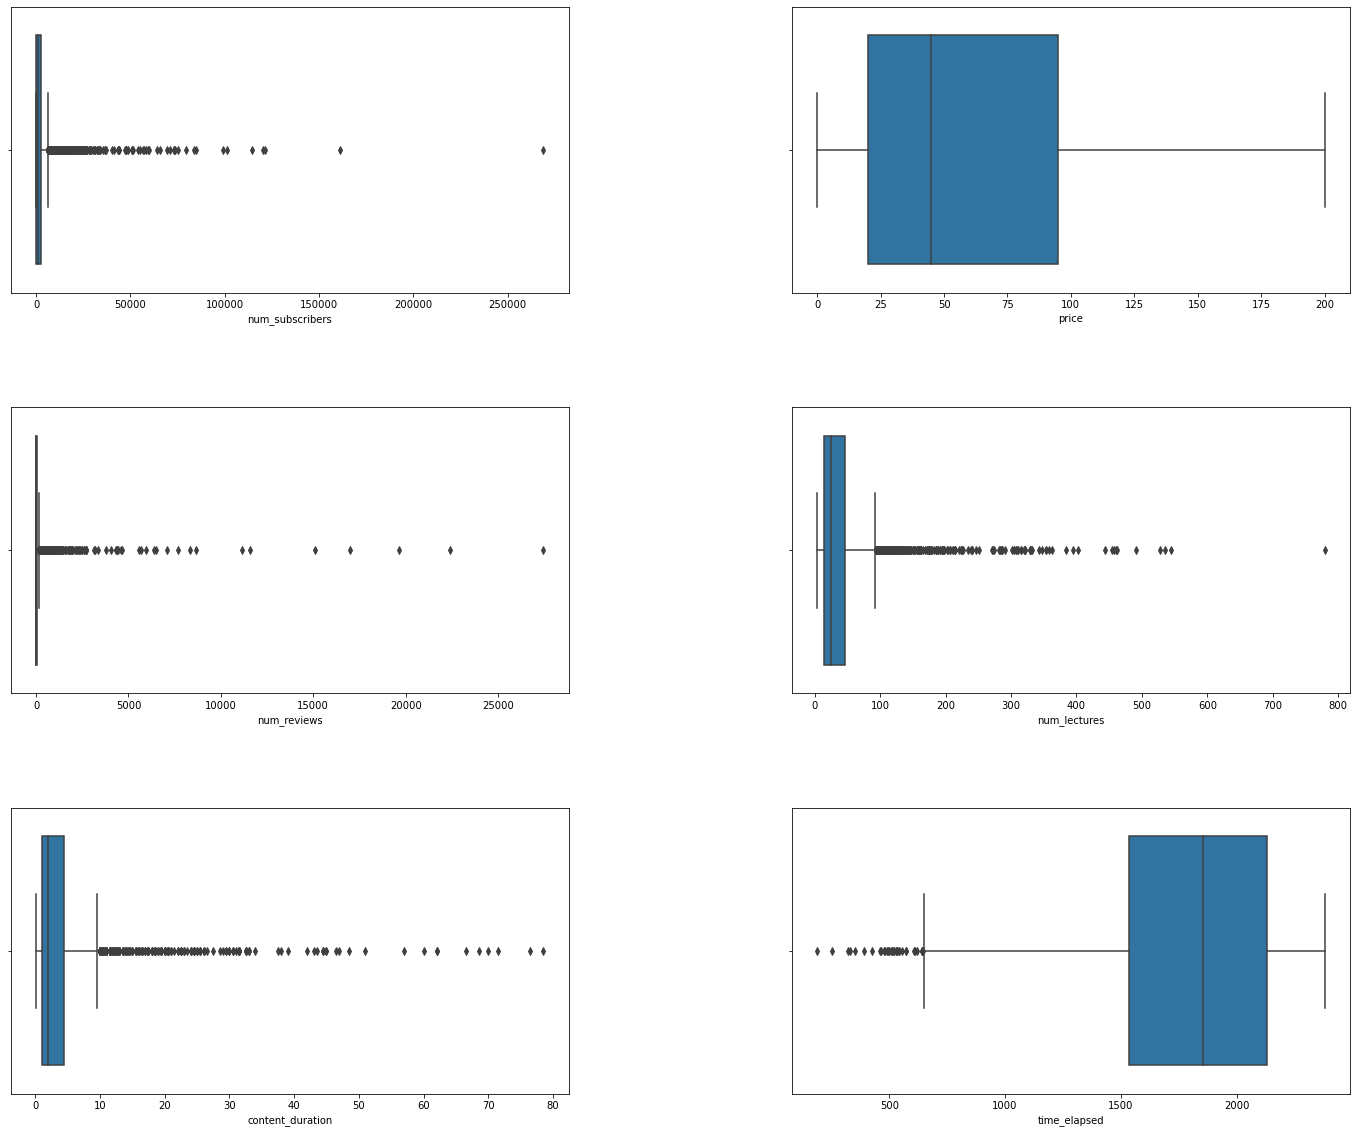

In [17]:
fig = plt.figure(figsize=(24,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1

for factor in num_data:
    ax = fig.add_subplot(3, 2, i)
    g = sns.boxplot(df1[factor])
    i += 1

plt.savefig('reg_boxplots.png')

In [ ]:
df1.head()

# Log Transformation

In [22]:
df2 = df1.copy()

df2['num_subscribers'] = np.log(df2['num_subscribers']+1)
df2['num_reviews'] = np.log(df2['num_reviews']+1)
df2['content_duration'] = np.log(df2['content_duration'])
df2['num_lectures'] = np.log(df2['num_lectures'])


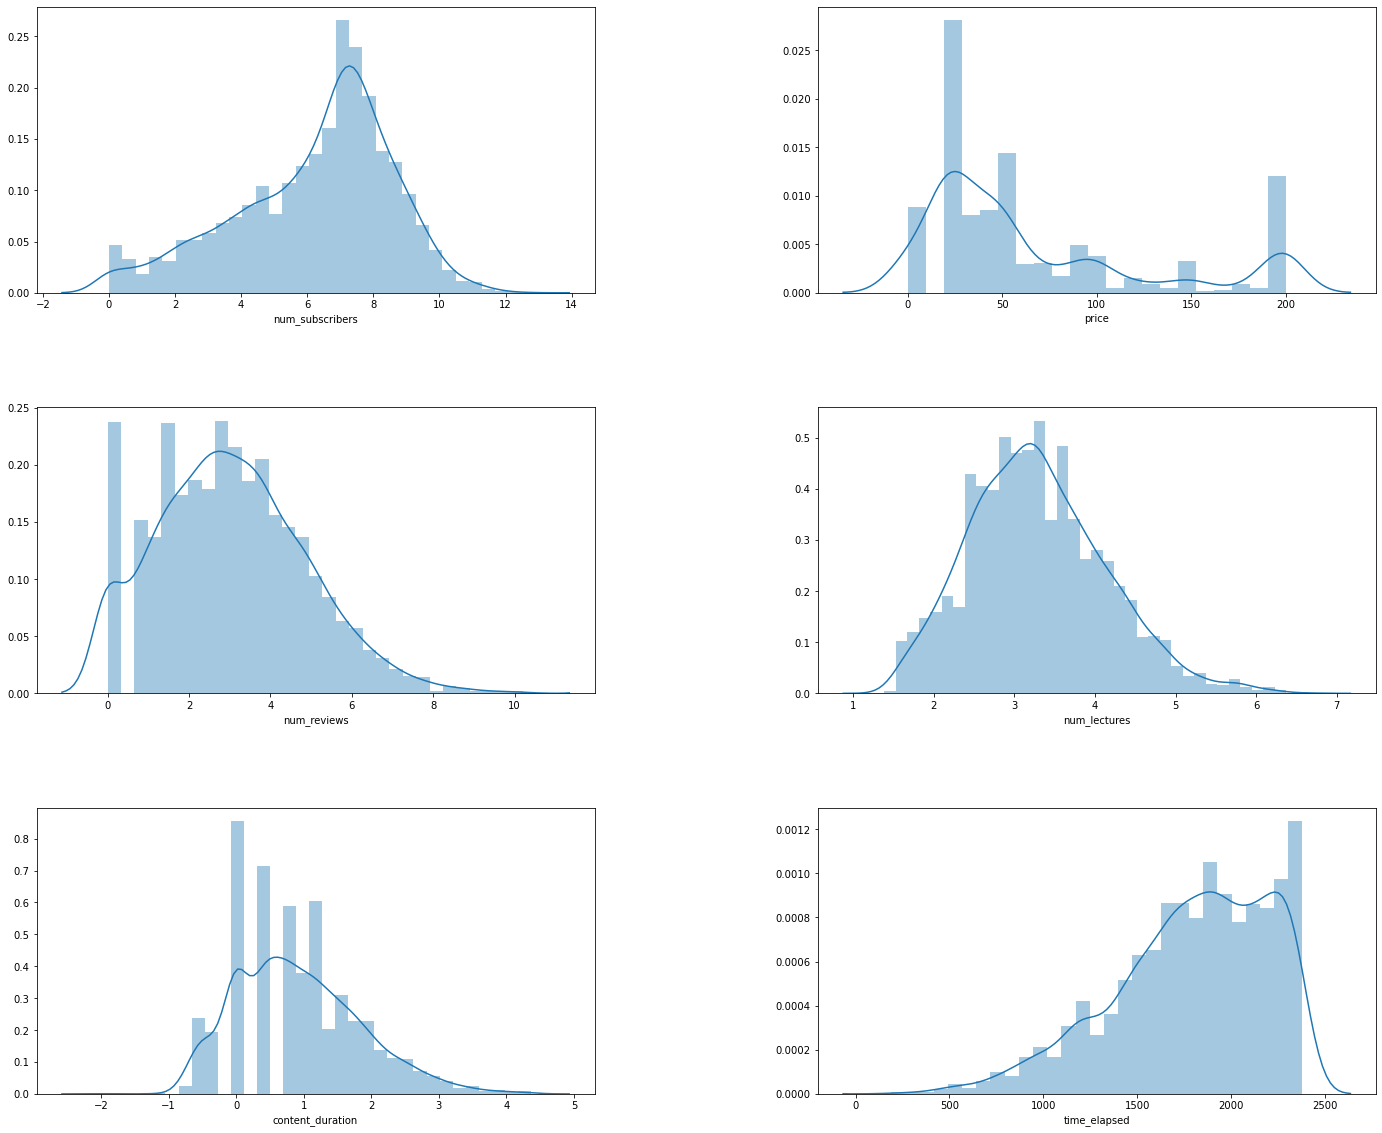

In [23]:
fig = plt.figure(figsize=(24,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1

for factor in num_data:
        ax = fig.add_subplot(3, 2, i)
        g = sns.distplot(df2[factor])
        i += 1

plt.savefig('log_histograms.png')

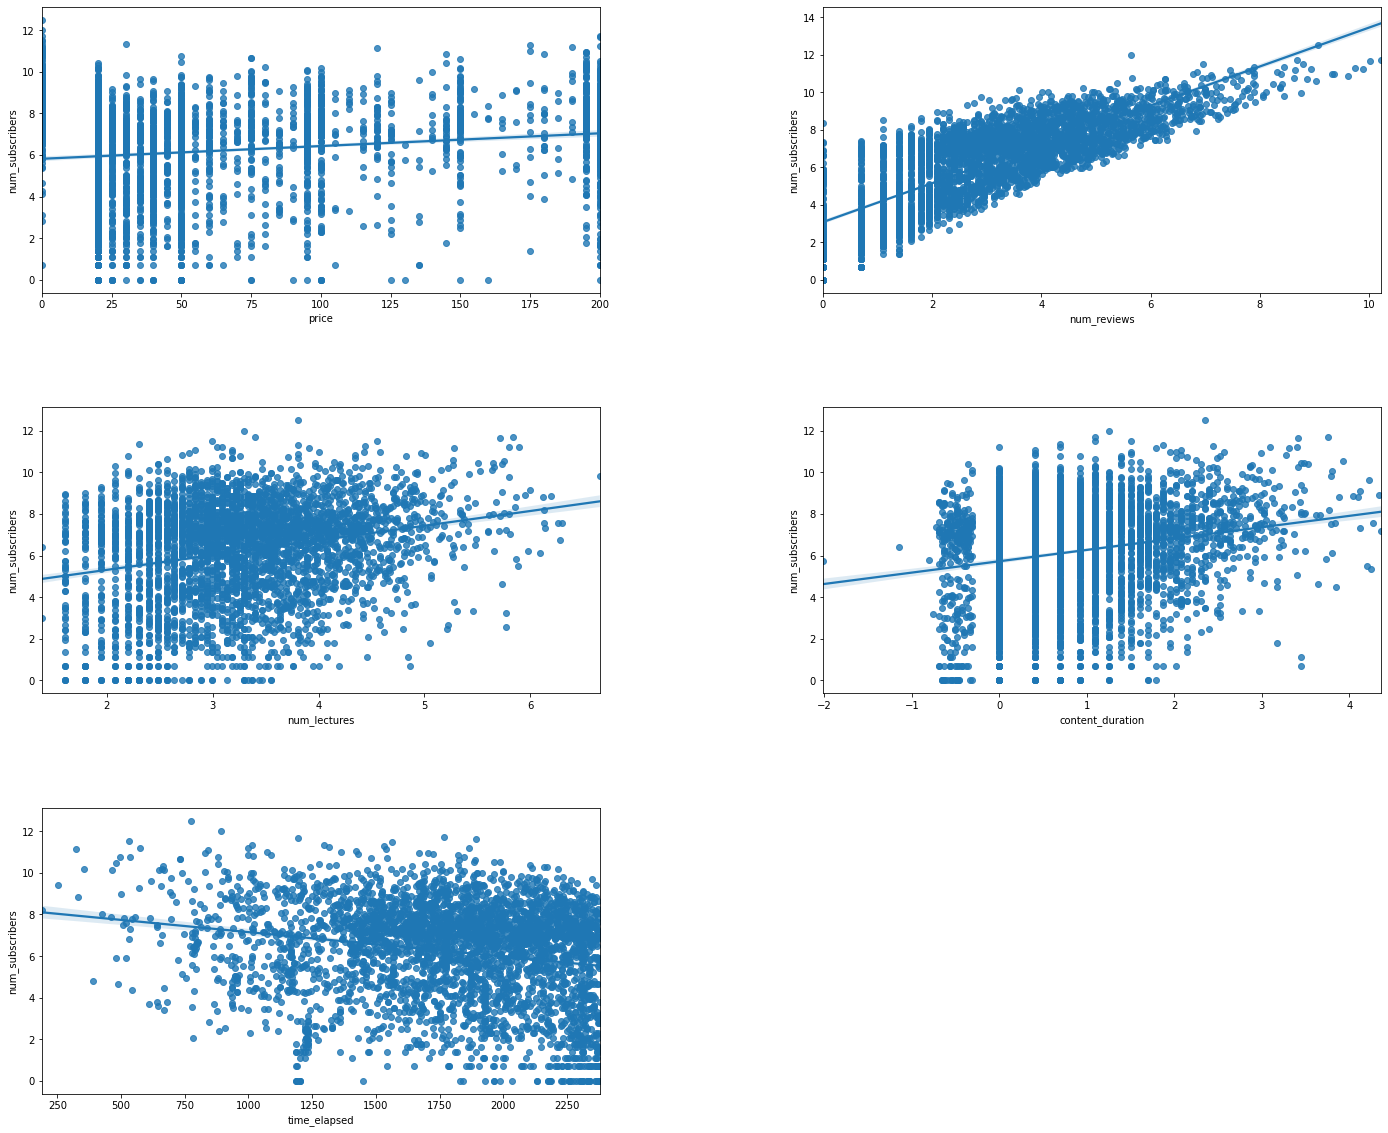

In [24]:
fig = plt.figure(figsize=(24,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1

for factor in num_data:
    if factor != 'num_subscribers':
        ax = fig.add_subplot(3, 2, i)
        g = sns.regplot(data=df2, x = factor, y="num_subscribers", ax=ax)
        i += 1

plt.savefig('log_scatterplots.png')

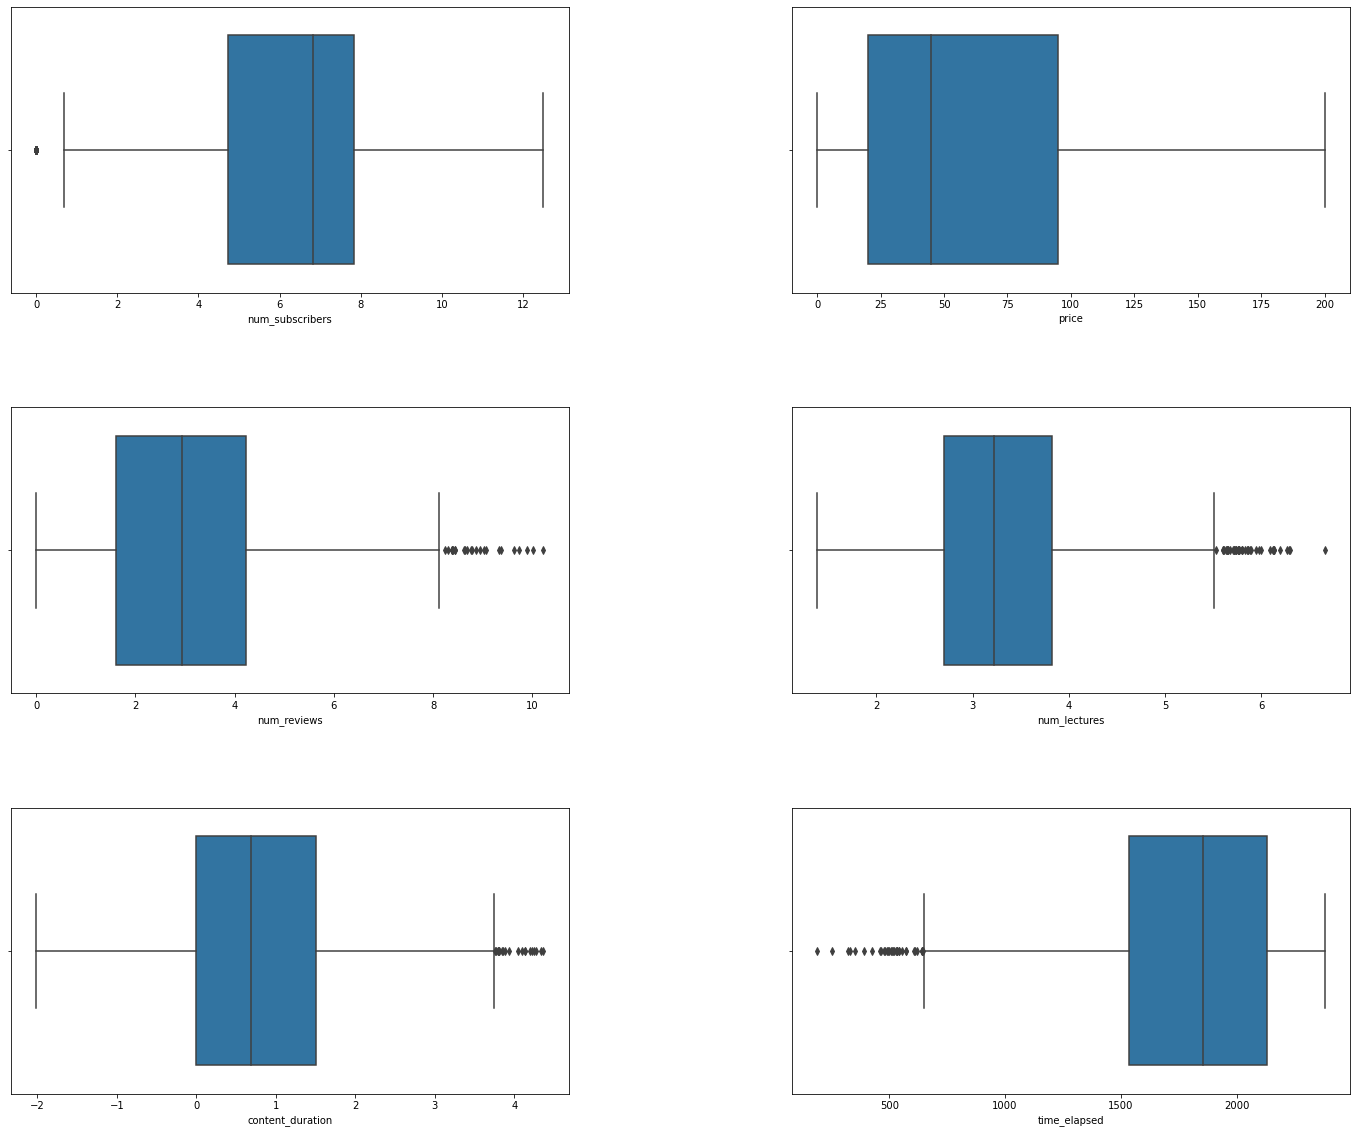

In [25]:
fig = plt.figure(figsize=(24,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1

for factor in num_data:
    ax = fig.add_subplot(3, 2, i)
    g = sns.boxplot(df2[factor])
    i += 1

plt.savefig('log_boxplots.png')

## Log transformation model and stepwise selection

In [20]:
model = ols(model_params, data = df2).fit()

In [29]:
model.bse


Intercept              0.113145
price                  0.000415
num_reviews            0.015601
num_lectures           0.049727
content_duration       0.044641
time_elapsed           0.000058
all_levels             0.055770
beginner_level         0.058978
expert_level           0.146509
intermediate_level     0.071392
business_finance       0.042514
graphic_design         0.054296
musical_instruments    0.055266
web_development        0.055558
dtype: float64

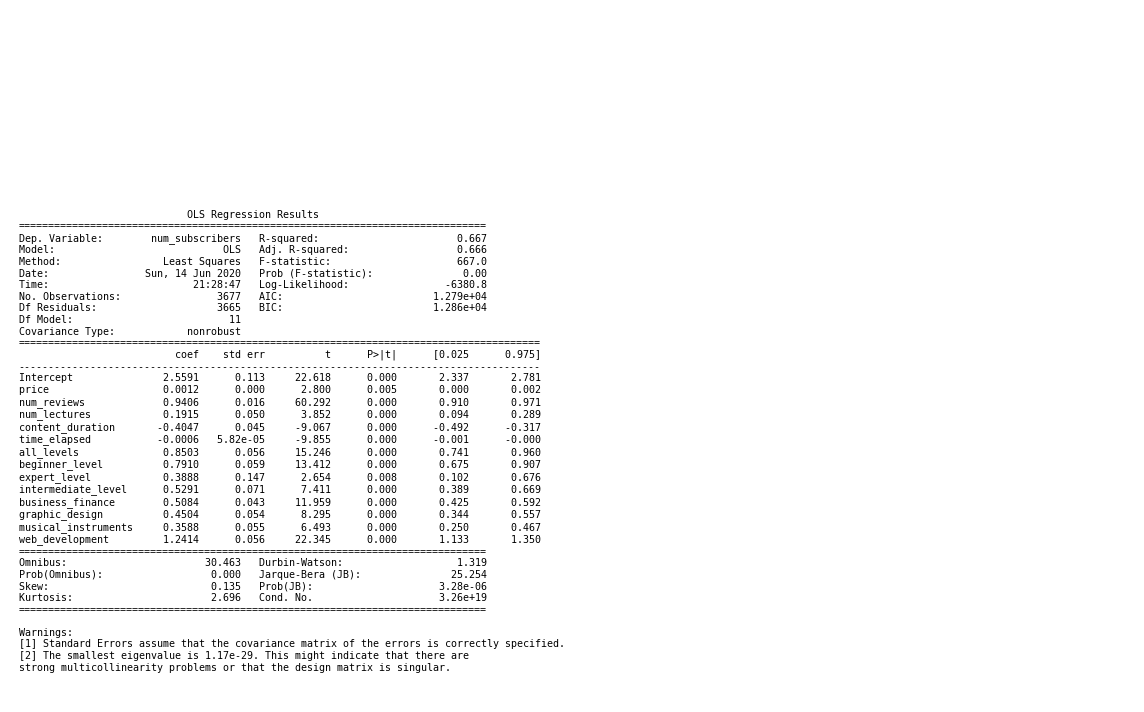

In [21]:
plt.rc('figure', figsize=(16, 10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('log_output.png')

NameError: name 'ProbPlot' is not defined

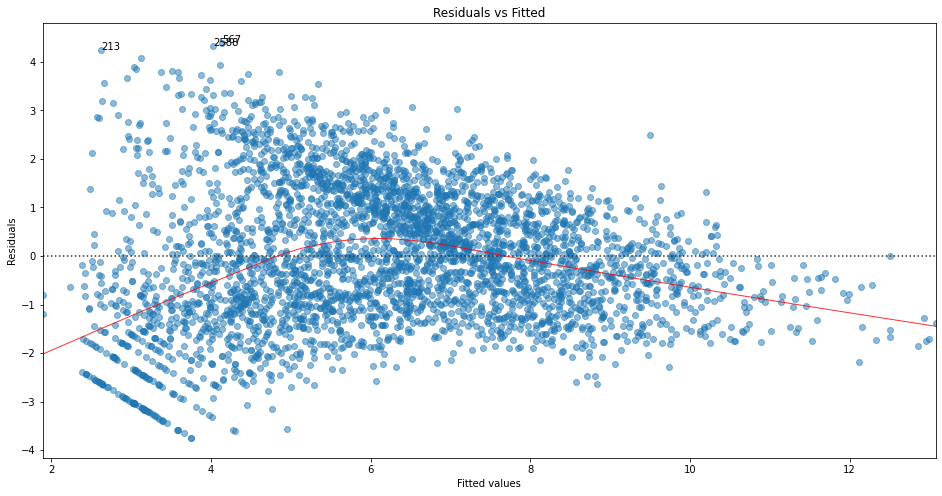

In [16]:
x = df2.drop(['num_subscribers'], axis=1)
y = df2['num_subscribers']
diagnostic_plots(x, y)

### Stepwise regression model (Log)

In [17]:
stepresult = stepwise_selection(x, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  num_reviews                    with p-value 0.0
Add  web_development                with p-value 7.55654e-31
Add  time_elapsed                   with p-value 9.79232e-19
Add  content_duration               with p-value 8.36851e-19
Add  intermediate_level             with p-value 9.38773e-06
Add  num_lectures                   with p-value 7.0207e-05
Add  price                          with p-value 0.0023287


num_subscribers ~  + num_reviews + web_development + time_elapsed + content_duration + intermediate_level + num_lectures + price


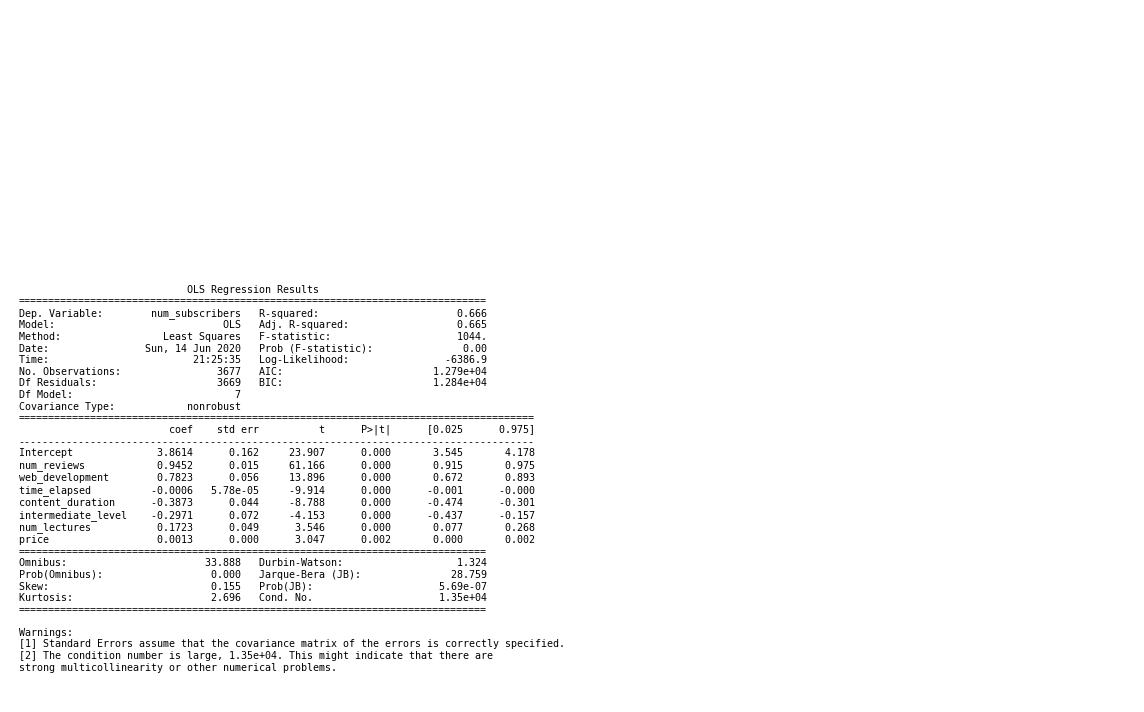

In [18]:
red_params = 'num_subscribers ~ '
for i in stepresult:
    red_params += " + " + i
    
print(red_params)
model = ols(red_params, data = df2).fit()
plt.rc('figure', figsize=(16, 10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('log_output_stepwise.png')

In [ ]:
x = df2[stepresult]
y = df2['num_subscribers']
diagnostic_plots(x, y)